# Multilabel classification

Automatically created module for IPython interactive environment


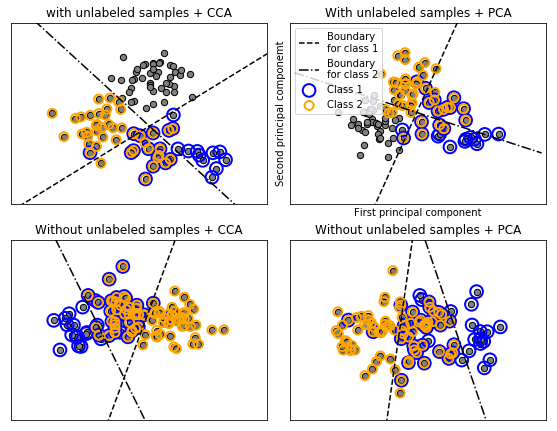

In [9]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

def plot_hyperplane(clf, min_x,max_x,linestyle,label):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5,max_x + 5) # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0] / w[1])
    plt.plot(xx,yy,linestyle,label=label)
    
def plot_subfigure(X,Y,subplot,title,transform):
    if transform == 'pca':
        X = PCA(n_components = 2).fit_transform(X)
    elif transform == 'cca':
        X = CCA(n_components = 2).fit(X,Y).transform(X)
    else:
        raise ValueError
    
    min_x = np.min(X[:,0])
    max_x = np.max(X[:,0])
    
    min_y = np.min(X[:,1])
    max_y = np.max(X[:,1])
    
    classif = OneVsRestClassifier(SVC(kernel = 'linear'))
    classif.fit(X,Y)
    
    plt.subplot(2,2,subplot)
    plt.title(title)
    
    zero_class = np.where(Y[:,0])
    one_class = np.where(Y[:,1])
    plt.scatter(X[:,0],X[:,1],s=40,c='gray',edgecolors=(0,0,0))
    plt.scatter(X[zero_class,0],X[zero_class,1],s=160,edgecolors='b',facecolors='none',linewidths=2,label="Class 1")
    plt.scatter(X[one_class,0],X[one_class,1],s=80,edgecolors='orange',facecolors='none',linewidths=2,label='Class 2')
    plot_hyperplane(classif.estimators_[0],min_x,max_x,'k--','Boundary\nfor class 1')
    plot_hyperplane(classif.estimators_[1],min_x,max_x,'k-.','Boundary\nfor class 2')
    plt.xticks(())
    plt.yticks(())
    
    plt.xlim(min_x - .5 * max_x ,max_x + .5 * max_x)
    plt.ylim(min_x - .5 * max_y ,max_y + .5 * max_y)
    if subplot == 2:
        plt.xlabel('First principal component')
        plt.ylabel('Second principal componemt')
        plt.legend(loc = 'upper left')
        
plt.figure(figsize = (8,6))

X,Y = make_multilabel_classification(n_classes = 2,n_labels = 1,allow_unlabeled = True,random_state = 1)
plot_subfigure(X,Y,1,'with unlabeled samples + CCA','cca')
plot_subfigure(X,Y,2,'With unlabeled samples + PCA','pca')

X,Y = make_multilabel_classification(n_classes = 2,n_labels=1,allow_unlabeled=False,random_state = 1)

plot_subfigure(X,Y,3,'Without unlabeled samples + CCA','cca')
plot_subfigure(X,Y,4,'Without unlabeled samples + PCA','pca')

plt.subplots_adjust(.04,.02,.97,.94,.09,.2)
plt.show()

# Faces recognition example using eigenfdaces and SVMs

In [ ]:
from __future__ import print_function

from time import time 
import logging 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,format='%(asctime)s %(message)s')

# #########################################################################
# Download the data, if not alreadyon disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70,resize=0.4)

# instrospect the images arrays to find the shapes (for plotting)
n_samples,h,w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel)
# position info is ignored by this model
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('Total dataset size:')
print('n_sample: %d' % n_samples)
print('n_features: %d'%n_features)
print('n_classes: %d'%n_classes)

# ########################################################################
# Split into a training set and test set using a stratified k fold
# split into a training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state = 42)

# ########################################################################
# Compute a PCA (eigebfaces) on the face dataset(treated as unlabeled dataset):
# unsupervised feature extraction / dimensionality reduction
n_components = 150
print("Extracting the top %d eigenfaces from %d faces"%(n_components,X_train.shape[0]))
t0 = time()
pca = PCA(n_components = ncomponent,svd_solver = 'randomized',whiten=True).fit(X_train)
print('done in %0.3fs' % (time() - t0))
eigenfaces = pca.components_.reshape((n_components,h,w))
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.trandform(X_test)
print("done in %0.3fs"%(time()-t0))

# ########################################################################
# Train a SVM clasification model
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'c':[1e3,5e3,1e4,5e4,1e5],'gamma':[0.0001,0.0005,0.001,0.005,0.01,0.1],}
clf = clf.fit(X_train_pca,y_train)
print("done in %0.3fs"%(time()-t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

# ########################################################################
# Quantiative evaluation of the model quality on the test set 

print("Predicting people's name on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print('done in %0.3fs'%(time() - t0))

print(classification_report(y_test,y_pred,target_names=target_names))
print(confusion_matrix(y_test,y_pred,labels = range(n_classes)))

# ########################################################################
# Qualitative evaluation of the predictions using matplotlib 

def plot_gallery(images,titles,h,w,n_rows = 3,n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8*n_col,2.4*n_row))
    plt.subplots_adjust(bottom=0,left=.01,right=.99,top=.90,hspace=.35)
    for i in range(n_row *  n_col):
        plt.subplot(n_row,n_col,i+1)
        plt.imshow(images[i].reshape((h,w)),cmap=plt.cm.gray)
        plt.title(titles[i],size=12)
        plt.xticks(())
        plt.yticks(())
        
# plot the result of the prediction on a portion of the testset
def title(y_pred,y_test,target_names,i):
    pred_name = target_names[y_pred[i].rsplit('',1)[-1]]
    true_name = target_names[y_test[i].rsplit('',1)[-1]]
    return 'predicted:%s\ntrue: %s'%(pred_name,true_name)
prediction_titles = [title(y_pred,y_test,target_names,i) for i in range(y_pred.shape[0])]
plot_gallery(X_test,prediction_titles,h,w)

# Plot the gallery of the most significant eigenances

eigenface_titles = ['eigenfaces %d'%i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces,eigenface_titles,h,w)
plot.show()



2019-02-01 22:36:10,550 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012


Automatically created module for IPython interactive environment


2019-02-01 22:36:28,782 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2019-02-01 22:36:36,605 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2019-02-01 22:36:51,942 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


# Recognizing hand-written digits

An example showing how the scikit-learn can be used to recognized images of hand-written digits

Automatically created module for IPython interactive environment
Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) : 
              precision    recall  f1-score   support

          0       1.00      0.99      0.99        88
          1       0.99      0.97      0.98        91
          2       0.99      0.99      0.99        86
          3       0.98      0.87      0.92        91
          4       0.99      0.96      0.97        92
          5       0.95      0.97      0.96        91
          6       0.99      0.99      0.99        91
          7       0.96      0.99      0.97        89
          8       0.94      1.00      0.97        88
          9       0.93      0.98      0.95        92

avg / total       0.97      0.97      0.97       899
 

Confusion matrix: 
 [[87  0  

D:\Python-install\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\Python-install\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


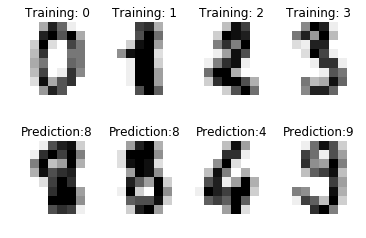

In [8]:
print(__doc__)

import matplotlib.pyplot as plt 

# import datasets,classifier,perforamnce metric
from sklearn import svm,metrics,datasets

# the digit dataset
digits = datasets.load_digits()
# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images,digits.target))
for index,(image,label) in enumerate(images_and_labels[:4]):
    plt.subplot(2,4,index+1)
    plt.axis('off')
    plt.imshow(image,cmap=plt.cm.gray_r,interpolation='nearest')
    plt.title('Training: %i'%label)
    
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples,-1))

# Create a classifier :a support vector classifier
classifier = svm.SVC(gamma=0.001)

# we learn the digits on the first half of the digits
classifier.fit(data[:n_samples // 2],digits.target[:n_samples // 2])

# Now predict the value of the digit on the second half
expected = digits.target[n_samples // 2:]
predicted = classifier.predict(data[n_samples // 2:])

print("Classification report for classifier %s : \n %s \n" % (classifier,metrics.classification_report(expected,predicted)))
print("Confusion matrix: \n %s" % metrics.confusion_matrix(expected,predicted))

images_and_predictions = list(zip(digits.images[n_samples // 2:],predicted))
for index,(image,prediction) in enumerate(images_and_predictions[:4]):
    plt.subplot(2,4,index+5)
    plt.axis('off')
    plt.imshow(image,cmap=plt.cm.gray_r,interpolation='nearest')
    plt.title('Prediction:%i'%prediction)
plt.show()